In [0]:
import tensorflow as tf

In [0]:
tf.__version__

'2.2.0-rc4'

In [0]:
!pip install -q imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

***Loading data***

In [0]:
(train_img, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


***Reshaping the data and converting its type and normalizing the data***

In [0]:
train_img.shape[0]

60000

In [0]:
#Reshaping the data and converting its type
train_img = train_img.reshape(train_img.shape[0],28,28,1).astype('float32')
#Normalization of data in the range [-1,1]
train_img = (train_img - 127.5) / 127.5

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

***Batch and shuffle the data***

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_img).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

***Generator Model***

In [0]:
def make_generator_model():
  model = tf.keras.Sequential([
              # Dense Layer
              layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
              layers.BatchNormalization(),
              layers.LeakyReLU(),
              layers.Reshape((7,7,256)),
              # Conv2DTranspose Layers
              layers.Conv2DTranspose(128,(5,5), strides=(1,1), padding='same', use_bias=False),
              layers.BatchNormalization(),
              layers.LeakyReLU(),

              layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
              layers.BatchNormalization(),
              layers.LeakyReLU(),

              layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False),
              layers.BatchNormalization(),
              layers.LeakyReLU()
  ])
  return model

***Creating an image using Generator without training***

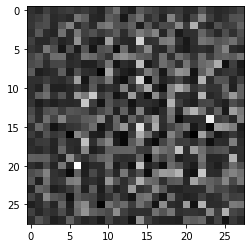

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0,:,:,0], cmap='gray')

***Discriminator Model***

In [0]:
def make_discriminator_model():
  model = tf.keras.Sequential([
                # Conv2D layers aka 2D convolutions
                layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),
                layers.LeakyReLU(),
                layers.Dropout(0.3),
                
                layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
                layers.LeakyReLU(),
                layers.Dropout(0.3),
                # Flattening the image
                layers.Flatten(),
                # Dense Layer
                layers.Dense(1)
  ])
  return model

***Classifying generated image as real or fake using Discriminator***

In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)
if decision < 0:
  print('Fake Image')
else:
  print('Real Image')

tf.Tensor([[8.353386e-05]], shape=(1, 1), dtype=float32)
Real Image


***Define Loss Function***

In [0]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

***Discriminator Loss***

In [0]:
def get_discriminator_loss(real_op, fake_op):
  real_loss = loss(tf.ones_like(real_op), real_op)
  fake_loss = loss(tf.zeros_like(fake_op), fake_op)
  total_loss = real_loss + fake_loss
  return total_loss

***Generator Loss***

In [0]:
def get_generator_loss(fake_op):
  return loss(tf.ones_like(fake_op), fake_op)

***Generator and Discriminator Optimizers***

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

***Checkpoints***

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

***Training Loop***

In [0]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    generated_image = generator(noise, training = True)

    real_op = discriminator(images, training = True)
    fake_op = discriminator(generated_image, training = True)
    generator_loss = get_generator_loss(fake_op)
    discriminator_loss = get_discriminator_loss(real_op, fake_op)

    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    gradients_of_discriminator = dis_tape.gradient(discriminator_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

***Training***

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    # for each batch of data, get gradients and generated image and its verification by discriminator
    for img_batch in dataset:
      train_step(img_batch)
    # Produce gif on go
    display.clear_output(wait=True)
    # Generate image and save them
    generate_and_save_images(generator, epoch+1, seed)
    # Save model in 15 seconds
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
  
  # Genearate after final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

***Generate and Save Images***

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  # Plotting images 
  for i in range(predictions.shape[0]):
    plt.plot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  # Saving figure
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

***Start Traing the model***

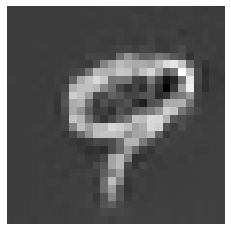

Time for epoch 239 is 13.093102931976318 sec


In [0]:
train(train_dataset, EPOCHS)

***Restore latest checkpoint***

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

***Creating GIF***

In [0]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
display_image(EPOCHS)

***Creating animated GIF***

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

***Downloading GIF***

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)